# <font> <center> Advanced Machine Learning </font>
## <font> <center> Group 9</font>
## <font> <center> March 2025</font>

## <font> Aperçu :</font>
<font size=5>
<ul>
    <li>Section 1: L'Introduction</li>
    <li>Section 2: L'Analyse exploratoire</li>
    <li>Section 3: L'Ingénerie de caractéristiques</li>
    <li>Section 4: Modélisation</li>
    <li>Section 5: Évaluation</li>
</ul>
</font>

# L'Introduction

Dans le cadre de cette analyse, nous allons concevoir des modèles visant à améliorer la prédiction des taux de survie après une greffe de cellules hématopoïétiques allogéniques (HCT). L'objectif est de garantir à chaque patient une chance équitable de réussite, quelle que soit son origine.

Améliorer les prédictions de survie pour les patients ayant reçu une greffe de HCT représente un défi majeur dans le domaine de la santé. Les modèles prédictifs actuels peinent souvent à prendre en compte les disparités liées au statut socio-économique, à l'origine ethnique et à la localisation géographique. Le défi consiste à développer des modèles prédictifs avancés pour les greffes de HCT, visant à améliorer à la fois la précision et l’équité des prédictions de survie.

Ce jeu de données contient 59 variables liées à la transplantation de cellules souches hématopoïétiques (HSCT), englobant diverses caractéristiques démographiques et médicales des receveurs et des donneurs, telles que l'âge, le sexe, l'origine ethnique, l'état de santé et les détails du traitement. L'objectif principal est d'analyser la survie sans événement, représentée par la variable efs, tandis que la durée jusqu'à cet événement est mesurée par la variable efs_time.

Ainsi, nous appliquons l'analyse de survie, qui permet d'étudier des données où le temps jusqu'à la survenue d'un événement constitue le principal sujet d'intérêt. Dans l'analyse de survie, et cela s'applique également à notre cas, il est fréquent de ne pas disposer des temps exacts de défaillance pour toutes les observations, car les données de durée de vie sont souvent "censurées". Cela s'explique par le fait que, pour certains individus, l'événement d'intérêt ne s'est pas encore produit à la fin de l'étude. Cette situation est connue sous le nom de censure à droite : certains sujets peuvent en effet survivre au-delà de la durée de l'étude.

Nous nous intéressons à l'impact d'un facteur de risque ou d'un traitement sur le temps jusqu'à l'événement. Les prédictions en analyse de survie peuvent concerner la fonction de survie ou la fonction de risque. En tout cas, il est possible de générer des scores de risque à partir de tous les modèles de survie.

Ce sont les scores de risques qui nous intéressent dans cette analyse. Nous utilisons l'indice de concordance (C-index) pour évaluer la capacité du modèle à fournir un classement fiable des temps de survie en fonction des scores de risque individuels :

$$\text{C-index} = \frac{\sum_{i,j} \mathbf{1}_{T_j < T_i} \cdot \mathbf{1}_{\eta_j > \eta_i} \cdot \delta_j}{\sum_{i,j} \mathbf{1}_{T_j < T_i} \cdot \delta_j}$$

où
* $\eta_i$, le score de risque $i$
* $\mathbf{1}_{T_j < T_i} = 1$ si $T_j < T_i$ sinon $0$
* $\mathbf{1}_{\eta_j > \eta_i} = 1$ si $\eta_j > \eta_i$ sinon $0$


Pour cette analyse, nous ajustons l'indice de concordance standard afin de tenir compte de la stratification raciale, garantissant ainsi que les résultats de chaque groupe racial sont pondérés de manière égale dans l'évaluation du modèle. L'indice de concordance stratifié est calculé comme la moyenne moins l'écart-type des scores de l'indice de concordance calculés au sein des catégories raciales des receveurs. Un score plus élevé garantit que les prédictions sont non seulement précises dans l'ensemble, mais également équitables à travers les différentes populations de patients.


In [ ]:
!pip install lifelines
!pip install xgboost
!pip install sksurv
!pip install optuna
!pip install scikit-survival

!pip install catboost

In [1]:
from itertools import combinations
from random import choice
from typing import Any, Callable, Iterable

import matplotlib.pyplot as plt
import numpy as np
import optuna
from catboost import CatBoostClassifier, CatBoostRegressor
from lifelines import (
    CoxPHFitter,
    LogLogisticAFTFitter,
    LogNormalAFTFitter,
    WeibullAFTFitter,
)
from lifelines.utils import concordance_index
from lightgbm import LGBMClassifier, LGBMRegressor
from numpy import array, concatenate, mean, median, nan, ndarray, sqrt, var
from pandas import DataFrame, Series, crosstab, get_dummies, isna, options, read_csv
import pandas as pd
import seaborn as sns
from seaborn import FacetGrid, histplot, kdeplot
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from xgboost import XGBClassifier, XGBRegressor


options.mode.chained_assignment = None
IN_DRIVE = False
if IN_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  filepath      = '/content/drive/MyDrive/Ue_Machine_learning/'
else:
  filepath = ''

c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = read_csv(filepath + 'dataset/train.csv')
test_data = read_csv(filepath + 'dataset/test.csv')

# L'Analyse exploratoire

### La taille de données

In [3]:
print(f'Our dataset has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Our test dataset has {test_data.shape[0]} rows and {test_data.shape[1]} columns')
train_data.head()

Our dataset has 28800 rows and 60 columns
Our test dataset has 3 rows and 58 columns


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


### Les valeurs manquantes

In [4]:
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values>0].sort_values(ascending=False)
print(missing_values)

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
hla_high_res_10            7163
hla_high_res_8             5829
hla_high_res_6             5284
hla_match_dqb1_high        5199
hla_low_res_10             5064
conditioning_intensity     4789
hla_match_c_high           4620
hla_match_a_high           4301
hla_nmdp_6                 4197
hla_match_dqb1_low         4194
hla_match_b_high           4088
hla_low_res_8              3653
hla_match_drb1_high        3352
hla_low_res_6              3270
hla_match_c_low            2800
hla_match_drb1_low         2643
hla_match_b_low            2565
cardiac                    2542
peptic_ulcer               2419
hla_match_a_low            2390
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_di

L'exploration des valeurs manquantes révèle plusieurs tendances intéressantes dans le dataset :

1. **Variables fortement manquantes (>50%) :**

  - tce_match (18,996)

  - mrd_hct (16,597)

  - cyto_score_detail (11,923)

  - tce_div_match (11396)
  -  tce_imm_match (11133)

Ces variables sont très incomplètes et pourraient nécessiter une imputation ou une suppression selon leur importance pour la prédiction.

2. **Données HLA (Typage génétique du donneur et du receveur) :**

Plusieurs variables liées au typage HLA ont un taux de valeurs manquantes significatif (entre 3,000 et 7,000).

Ces informations sont essentielles pour évaluer la compatibilité entre le donneur et le receveur, donc leur absence pourrait affecter les modèles prédictifs.

3. **Scores médicaux et comorbidités :**

conditioning_intensity, comorbidity_score, karnofsky_score, dri_score ont un taux de valeurs manquantes modéré.

Les comorbidités (cardiac, diabetes, renal_issue, etc.) montrent également des absences notables.

Leur absence peut être due à un manque de diagnostic ou de suivi médical détaillé.

4. **Données démographiques et caractéristiques du donneur :**

ethnicity (587 valeurs manquantes), donor_age (1,808), donor_related (158) sont relativement complètes.

sex_match et vent_hist ont moins de 300 valeurs manquantes, donc leur impact sera limité.

**Plusieurs stratégies peuvent être envisagées : suppression des variables trop incomplètes, imputation (moyenne, médiane, modèles prédictifs), ou traitement spécifique par catégorie.**


## L'analyse de variables ciblées

In [5]:
efs0 = train_data[train_data['efs'] == 0]
efs1 = train_data[train_data['efs'] == 1]

<Axes: xlabel='efs_time', ylabel='Density'>

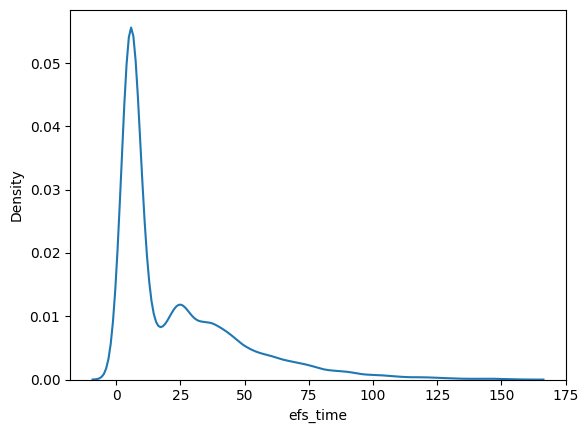

In [6]:
kdeplot(train_data['efs_time'])

- La densité est fortement asymétrique avec un pic près de 0, indiquant qu'une grande proportion de patients a un événement (échec) rapidement après la greffe.

- Une seconde bosse autour de 25 jours suggère une autre fréquence d'événements à court terme.

- Ensuite, la distribution s'étale sur des valeurs plus grandes avec une décroissance progressive, ce qui signifie que certains patients survivent beaucoup plus longtemps sans événement.

C:\Users\bensi\AppData\Local\Temp\ipykernel_18148\4212767677.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(efs0['efs_time'], label='Échec (efs=0)', shade=True)
C:\Users\bensi\AppData\Local\Temp\ipykernel_18148\4212767677.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(efs1['efs_time'], label='Succès (efs=1)', shade=True)


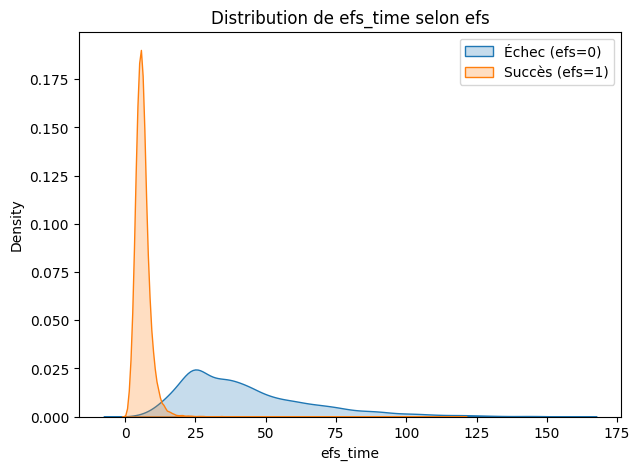

In [7]:
plt.figure(figsize=(7,5))
kdeplot(efs0['efs_time'], label='Échec (efs=0)', shade=True)
kdeplot(efs1['efs_time'], label='Succès (efs=1)', shade=True)
plt.xlabel('efs_time')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution de efs_time selon efs')
plt.show()


**Interprétation :**

Une grande partie des échecs surviennent très tôt après la greffe (le pic près de 0).

En revanche, les patients qui n’ont pas d’événement (succès, efs=0) peuvent avoir des efs_time beaucoup plus longs, ce qui explique la distribution plus large et étalée en bleu.

In [8]:
train_data.groupby('efs')['efs_time'].describe()


,count,mean,std,min,25%,50%,75%,max
efs,,,,,,,,
0.0,13268.0,43.121212,24.258854,3.212,25.2735,37.194,54.4525,156.819
1.0,15532.0,6.252439,3.386629,0.333,4.4770,5.803,7.3220,120.009


## L'analyse de l'âge dans les données

C:\Users\bensi\AppData\Local\Temp\ipykernel_18148\507364599.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(train_data['donor_age'].dropna(), label='Âge du donneur', shade=True)
C:\Users\bensi\AppData\Local\Temp\ipykernel_18148\507364599.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(train_data['age_at_hct'].dropna(), label='Âge du receveur', shade=True)


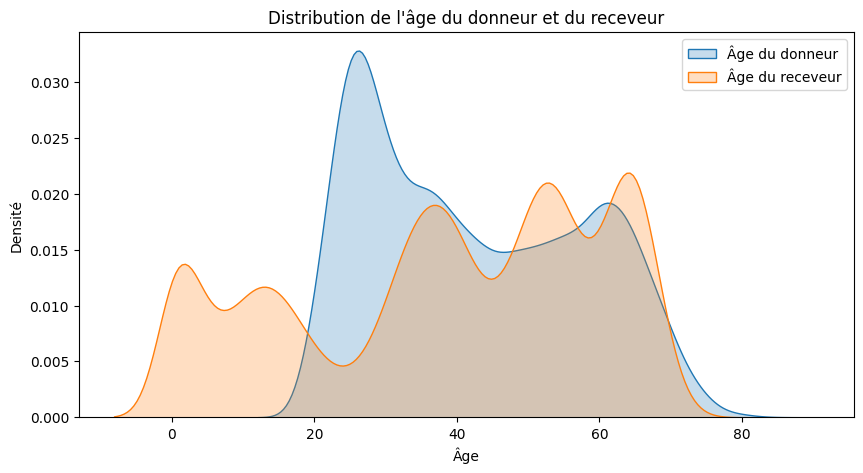

In [9]:
plt.figure(figsize=(10,5))
kdeplot(train_data['donor_age'].dropna(), label='Âge du donneur', shade=True)
kdeplot(train_data['age_at_hct'].dropna(), label='Âge du receveur', shade=True)
plt.xlabel('Âge')
plt.ylabel('Densité')
plt.legend()
plt.title("Distribution de l'âge du donneur et du receveur")
plt.show()

**Comparaison des distributions :** En comparant les deux courbes, on peut observer que les donneurs ont tendance à être plus jeunes que les receveurs. Cela est logique, car les donneurs doivent être en bonne santé et avoir une meilleure capacité de régénération cellulaire, ce qui est plus fréquent chez les jeunes individus.

**Implications pour le projet :** Ces distributions d'âge peuvent avoir des implications importantes pour les prédictions de survie post-HCT. Les différences d'âge entre donneurs et receveurs peuvent influencer les résultats de la greffe, y compris les taux de réussite et les complications potentielles.

## L'analyse du race dans les données

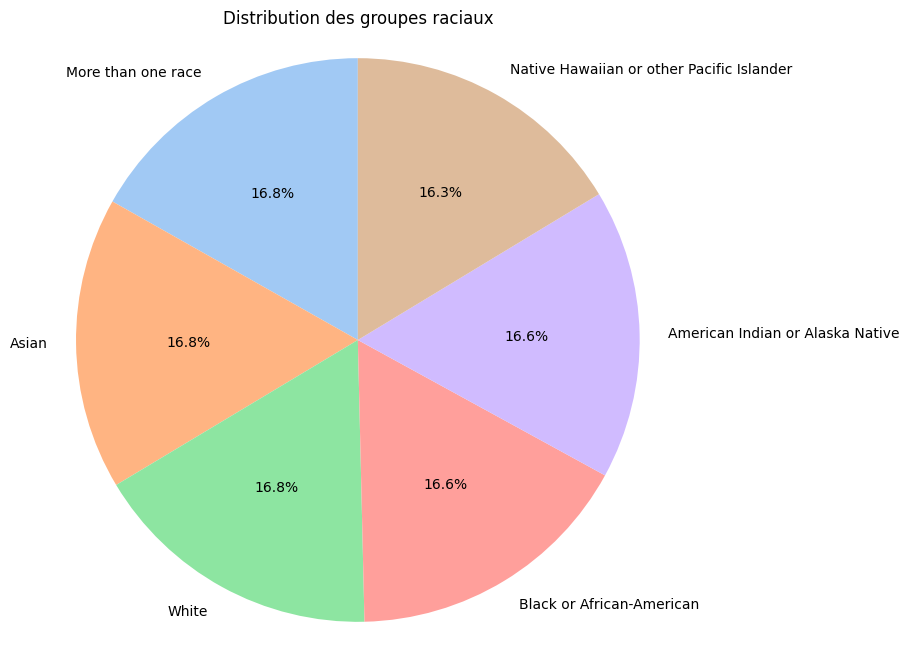

In [10]:
# Calculer le nombre d'occurrences par groupe dans la colonne 'race_group'
group_counts = train_data['race_group'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", len(group_counts)))
plt.title("Distribution des groupes raciaux")
plt.axis('equal')
plt.show()


**Répartition équilibrée :** Les différentes catégories raciales semblent être assez proches en proportion, autour de 16-17 % chacune, ce qui suggère une diversité des patients inclus dans l'étude.


**Impact sur l'équité en prédiction :** Si les données sont équilibrées entre les groupes raciaux, cela pourrait limiter les biais dans les modèles prédictifs.

# Traitement des données et Ingénierie de caractéristiques



### Traitement des lignes avec beaucoup de valeurs Nan


Enlever les lignes avec plus de 25 colonnes remplies de Nan

Cela représente environ 300 données sur un total de 28000

In [11]:
def remove_nan_lines(X_in: DataFrame):
    nan_counts = X_in.isnull().sum(axis=1)
    X_in = X_in[nan_counts <= 25]
    return X_in


### Remplissage des colonnes hla



In [12]:
pd.crosstab(train_data['hla_high_res_8'],train_data['hla_low_res_8'],dropna=False)

hla_low_res_8,2.0,3.0,4.0,5.0,6.0,7.0,8.0,NaN
hla_high_res_8,,,,,,,,
2.0,0,0,0,1,0,0,1,0
3.0,0,0,16,8,1,2,0,1
4.0,0,11,3186,443,99,26,10,45
5.0,1,3,491,577,342,156,55,23
6.0,0,4,95,243,418,479,250,31
7.0,0,0,17,92,309,918,1013,36
8.0,0,0,4,18,113,668,12678,87
NaN,0,5,450,231,206,354,1153,3430


On remarque que les valeurs les plus fréquentes se trouvent sur la diagonale. On complète ainsi les valeurs manquantes.



In [13]:
hla_high_columns = [
    "hla_match_c_high",
    "hla_high_res_8",
    "hla_high_res_6",
    "hla_high_res_10",
    "hla_match_dqb1_high",
    "hla_match_drb1_high",
    "hla_match_a_high",
    "hla_match_b_high",
]
hla_low_columns = [hla.replace('high','low') for hla in hla_high_columns]
hla_columns = [
    "hla_nmdp_6",
    *hla_high_columns,
    *hla_low_columns,
]
def fill_hla_na(X_in: DataFrame) -> DataFrame:
    for i in range(len(hla_low_columns)) :
        low = hla_low_columns[i]
        high = hla_high_columns[i]
        X_in[low]  = X_in[low].fillna(X_in[high])
        X_in[high] = X_in[high].fillna(X_in[low])
    return X_in

Remplissage des colonnes hla selon la valeur correspondante en haute/basse résolution pour le même allèle s'il est donné

Remplissage des colonnes HLA en utilisant la valeur la plus fréquente en utilisant différents allèles

In [14]:
def fillna_two_hla(X_in: DataFrame, col_1: str, col_2: str) -> DataFrame:
  cross_tab = crosstab(X_in[col_1], X_in[col_2], dropna=False)

  most_frequent_value_col_1 = cross_tab.idxmax(axis=1)
  most_frequent_value_col_2 = cross_tab.idxmax(axis=0)

  X_in[col_1] = X_in[col_1].fillna(X_in[col_2].map(most_frequent_value_col_2))
  X_in[col_2] = X_in[col_2].fillna(X_in[col_1].map(most_frequent_value_col_1))
  return X_in

def fillna_all_combinations(X_in: DataFrame) -> DataFrame:
    X_in = fill_hla_na(X_in)  # Appliquer fillna_hla d'abord

    # Générer toutes les combinaisons possibles de colonnes HLA (prises 2 par 2)
    for col_1, col_2 in combinations(hla_columns, 2):
        X_in = fillna_two_hla(X_in, col_1, col_2)

    return X_in

### Renommer les valeurs TCE et remplir les valeurs nan

On réduit d'une catégorie tce_match et on renomme les colonnes afin de les faire correspondre à tce_div_match. Ce sont 2 variables qui correspondent à la même chose ce qui nous permet de remplir les valeurs manquantes.

In [15]:
mapping_tce_match = {
    'Permissive mismatched'         : 'Permissive',
    'Permissive'                    : 'Permissive',
    'Bi-directional non-permissive' : 'Non-permissive', # GvH and HvG
    'Fully matched'                 : 'Fully matched',
    'GvH non-permissive'            : 'GvH non-permissive',
    'HvG non-permissive'            : 'HvG non-permissive'
}
rename_tce_cols = ['tce_div_match', 'tce_match']

def rename_tce_match(X_in: DataFrame) -> DataFrame:
    for col in rename_tce_cols:
        X_in[col] = X_in[col].cat.rename_categories(mapping_tce_match)
    return X_in

In [16]:
mapping_fillna_tce_match = {
    'Permissive'         : 'Permissive',
    'Non-permissive'     :  choice(['GvH non-permissive', 'HvG non-permissive']),
    'Fully matched'      : 'Permissive',
    'GvH non-permissive' : 'GvH non-permissive',
    'HvG non-permissive' : 'HvG non-permissive',
}

def fillna_tce_match(X_in: DataFrame) -> DataFrame:
    for i in range(len(X_in)):
      tce_match     = X_in.loc[i,'tce_match']
      tce_div_match = X_in.loc[i,'tce_div_match']

      if isna(tce_match) and isna(tce_div_match):
        continue

      if isna(tce_match):
        if tce_div_match in mapping_fillna_tce_match:
          X_in.loc[i,'tce_match'] = mapping_fillna_tce_match[tce_div_match]

      if isna(tce_div_match):
        if tce_match in mapping_fillna_tce_match:
          X_in.loc[i, 'tce_div_match'] = mapping_fillna_tce_match[tce_match]

    return X_in

### Cyto_score

De façon similaire, on change les noms des valeurs afin de pouvoir exploiter le lien entre cyto_score et cyto_score_detail pour compléter les valeurs manquantes

In [17]:
mapping_cyto_score = {
    'Poor'         : 'Poor',
    'Intermediate' : 'Intermediate',
    'Normal'       : 'Favorable',
    'Other'        : 'Intermediate',
    'Favorable'    : 'Favorable',
    'TBD'          : 'TBD',
    'Not tested'   : 'Not tested',
}

def fillna_cyto_score(X_in: DataFrame):
  X_in['cyto_score'] = X_in['cyto_score'].map(mapping_cyto_score)
  X_in['cyto_score'] = X_in['cyto_score'].fillna(X_in['cyto_score_detail'])
  X_in['cyto_score_detail'] = X_in['cyto_score_detail'].fillna(X_in['cyto_score'])
  return X_in

### Traitement de l'année de l'opération HCT

In [18]:
def reduce_year(X_in: DataFrame) -> DataFrame:
    X_in['year_hct']=X_in['year_hct'].replace(2020,2019) # only 4 rows
    X_in['year_hct'] = X_in['year_hct'] - 2000
    return X_in

### karnofsky score
Remplissage des valeurs avec 90, qui est une valeur assez commune et présente dans le dataset et qui correspond à un état normal

In [19]:
def fill_karnofsky_score(X_in: DataFrame):
    X_in['karnofsky_score'] = X_in['karnofsky_score'].fillna(90)
    return X_in

### Ajout de nouvelles features

In [20]:
def add_new_feat(X_in: DataFrame): ##not added yet, to test one by one
    X_in['donor_age-age_at_hct']=X_in['donor_age']-X_in['age_at_hct']
    X_in['comorbidity_score+karnofsky_score']=X_in['comorbidity_score']+X_in['karnofsky_score']
    X_in['comorbidity_score-karnofsky_score']=X_in['comorbidity_score']-X_in['karnofsky_score']
    X_in['comorbidity_score*karnofsky_score']=X_in['comorbidity_score']*X_in['karnofsky_score']
    X_in['comorbidity_score/karnofsky_score']=X_in['comorbidity_score']/X_in['karnofsky_score']
    X_in['is_cyto_score_same'] = (X_in['cyto_score'] == X_in['cyto_score_detail']).astype(int)
    return X_in

### Remplissage des valeurs manquantes avec 'Not done' pour certaines colonnes

In [21]:
def fillna_not_done(X_in: DataFrame):
    notDoneList = ["psych_disturb","diabetes","arrhythmia","renal_issue","pulm_severe","obesity","hepatic_severe","prior_tumor","peptic_ulcer","rheum_issue","hepatic_mild","cardiac","pulm_moderate"]
    for col in notDoneList:
        if 'Not done' not in X_in[col].cat.categories:
          X_in[col] = X_in[col].cat.add_categories('Not done')
        X_in[col] = X_in[col].fillna('Not done')
    return X_in

## Application du feature engineering sur notre dataset

In [22]:
X_train = train_data[[col for col in train_data.columns if col != "ID"]]
X_test  = test_data[[col for col in test_data.columns if col != "ID"]]

In [23]:

categorical_columns    = list(X_train.select_dtypes(object).columns)
X_train[categorical_columns] = X_train[categorical_columns].astype(str).astype('category')

categorical_columns = list(X_train.select_dtypes('category').columns)
numerical_columns   = list(set(X_train.columns) - set(categorical_columns) - set(["efs", "efs_time"]))

X_train[categorical_columns] = X_train[categorical_columns].astype(str).astype('category')
X_test[categorical_columns] = X_test[categorical_columns].astype(str).astype('category')
print(f'We have {len(categorical_columns)} categorical_columns')
print(f'We have {len(numerical_columns)}   numerical_columns')

races = list(X_train["race_group"].unique())
print(f'All races are : \n {races}')


We have 35 categorical_columns
We have 22   numerical_columns
All races are : 
 ['More than one race', 'Asian', 'White', 'American Indian or Alaska Native', 'Native Hawaiian or other Pacific Islander', 'Black or African-American']


In [24]:
def apply_feature_engineering (X: DataFrame) -> DataFrame:
  X = remove_nan_lines(X)
  X = fillna_all_combinations(X)
  X = fillna_cyto_score(X)
  X = fill_karnofsky_score(X)
  X = rename_tce_match(X)
  X = fillna_tce_match(X)
  X = fillna_not_done(X)
  X = reduce_year(X)
  X = add_new_feat(X)

  return X

X_train_feat_added = apply_feature_engineering(X_train)
X_test_feat_added  = apply_feature_engineering(X_test)

On transforme les colonnes catégoriques en des colonnes binaires avec le one-hot-encoding.
Puis on applique une normalisation par standardScaler et on complète les valeurs manquantes qui restent avec la médiane.
Nous utilisons scaler et imputer afin de pouvoir les réutiliser pour les données de test.

In [25]:
def get_ohe(X_in: DataFrame, categories: list[str]) -> DataFrame:
    X_ohe = get_dummies(X_in, columns=categories, drop_first=False)
    invalid_col_names = [f for f in X_ohe.columns if "<" in f]
    return X_ohe.rename(columns={f: f.replace("<", "_inf_") for f in invalid_col_names})


In [26]:
X_train_ohe = get_ohe(X_train_feat_added.drop(columns=["efs", "efs_time"]), categorical_columns)
X_test_ohe  = get_ohe(X_test_feat_added, categorical_columns)

#we could have missing ohe columns in test
missing_cols = list(set(X_train_ohe.columns) - set(X_test_ohe.columns)-set(['race_group']))
# Add missing columns efficiently
X_test_ohe = pd.concat([X_test_ohe, pd.DataFrame(0, index=X_test_ohe.index, columns=missing_cols)], axis=1)
X_test_ohe = X_test_ohe[X_train_ohe.columns] # same order

non_numerical_columns = [col for col in X_train_ohe.columns if col not in numerical_columns]

imputer = SimpleImputer(strategy='median')
X_train_ohe_filled = imputer.fit_transform(X_train_ohe)
X_train_ohe_filled = pd.DataFrame(X_train_ohe_filled, columns=X_train_ohe.columns)

scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train_ohe_filled[numerical_columns])
X_train_scaled_num = pd.DataFrame(X_train_scaled_num, columns=numerical_columns, index=X_train_ohe.index)
X_train_non_scaled = X_train_ohe_filled[non_numerical_columns]
X_train_scaled = pd.concat([X_train_scaled_num, X_train_non_scaled], axis=1)

X_test_ohe_filled = imputer.transform(X_test_ohe)
X_test_ohe_filled = pd.DataFrame(X_test_ohe_filled, columns=X_test_ohe.columns)


X_test_scaled_num = scaler.transform(X_test_ohe_filled[numerical_columns])
X_test_scaled_num = pd.DataFrame(X_test_scaled_num, columns=numerical_columns, index=X_test_ohe.index)
X_test_non_scaled = X_test_ohe_filled[non_numerical_columns]
X_test_scaled = pd.concat([X_test_scaled_num, X_test_non_scaled], axis=1)


In [27]:
columns_to_add = ["race_group", "efs", "efs_time"]
for col in columns_to_add:
    X_train_scaled[col] = train_data[col]

X_test_scaled['race_group'] = test_data['race_group'].astype('category')

On normalise la colonne efs_time afin d'obtenir des plages de valeurs entre 0 et 1 vu qu'on a des valeurs binaires pour efs

In [28]:
s = X_train_scaled['efs_time']

X_train_scaled['efs_time'] = (s - s.min()) / (s.max() - s.min())

X_train = X_train_scaled.copy()
X_test  = X_test_scaled.copy()


# Modélisation

Comme décrit dans l'introduction, dans l'analyse de survie, nous visons à modéliser la fonction de survie ou la fonction de risque (le risque instantané).

**La fonction de survie** \
La fonction de survie $S(t)$ donne la probabilité qu'un sujet survive au-delà du temps $t$. Si nous désignons $T>0$ comme la variable réponse, c'est-à-dire le temps de survie, la fonction de survie est définie par :
$$S(t)=P(T>t)=1-F(t)$$

où $F(t)$ est la fonction de réparition.

**La fonction de risque** \
La fonction de risque (hazard function) représente le taux instantané auquel un événement survient, à condition que l'individu ait survécu jusqu'à un moment donné $t$. Autrement dit, elle mesure la probabilité que l'événement se produise à un instant précis, en supposant qu'aucun événement ne s'est produit avant ce moment.

$$h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t \mid T \geq t)}{\Delta t}$$

**Méthodes d'ensemble** \
D'autres de modèles peuvent être utilisés, même s'ils ne modélisent pas directement la fonction de survie ou de risque. L'approche générale est de traiter les deux variables ciblées séparément, puis fusionner les résultats de manière prédéfinie afin d'obtenir les scores de risques.


**Modèles dans cette section**
1. Cox Proportional Hazards Model (la fonction de risque).
2. Accelerated Failure Time Model (la fonction de survie).
3. Random Survival Forests (la fonction de risque).
4. Méthodes d'ensemble (les deux variables ciblées modélisées séparément)


## Fonctions et Classes Utiles

Étant donné que nous utilisons des modèles provenant de plusieurs bibliothèques, qui pourraient ne pas avoir la même interface, nous avons écrit la classe GenericModel afin de simplifier l'implémentation.

Dans tous les modèles, nous effectuons la validation croisée (gérée par la fonction cross_validate ci-dessous) ainsi que le calcul du score C-index (get_c_index_by_race). GenericModel fournit l'interface requise pour ces deux fonctions.

L'idée est que, chaque fois que nous voulons utiliser un nouveau modèle, nous écrivons une classe qui hérite de GenericModel et qui encapsule l'objet du modèle de la bibliothèque. Cela nous permet de de faciliter leur intégration dans notre pipeline et de garantir la cohérence des évaluations.

In [29]:
class GenericModel:

    def __init__(self, model: Any) -> None:
        self.model = model

    def fit_model(self, *args, **kwargs) -> None:
        raise NotImplementedError

    def get_risk_scores(self, data: DataFrame) -> Iterable[float]:
        raise NotImplementedError

    def __getattr__(self, attr_name: str) -> Any:
        return getattr(self.model, attr_name)


def get_c_index_by_race(
        x_in: DataFrame,
        model: GenericModel,
    ) -> float:
    race_c_indexes = []
    x_feats = [f for f in x_in.columns if f not in ("race_group")]
    for race in races:

        df_race = x_in[x_in["race_group"] == race]

        c_index_race = concordance_index(
                        df_race['efs_time'],
                        -model.get_risk_scores(df_race[x_feats]),
                        df_race['efs'])

        race_c_indexes.append(c_index_race)

    return float(mean(race_c_indexes)-sqrt(var(race_c_indexes)))

def cross_validate(train_df: DataFrame, model: GenericModel, k: int = 5) -> float:

    stratify_col = train_df["race_group"]

    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    kfold_c_index_scores = []
    for train_index, val_index in kf.split(train_df, stratify_col):
        X_train_fold, X_val_fold = train_df.iloc[train_index], train_df.iloc[val_index]

        model.fit_model(X_train_fold)
        c_index = get_c_index_by_race(X_val_fold, model)

        kfold_c_index_scores.append(c_index)

    return mean(kfold_c_index_scores)



## Cox Proportional Hazards Model

Le modèle de Cox, ou modèle des hasards proportionnels, est une méthode statistique utilisée dans l'analyse de survie, tout en tenant compte de l’influence de plusieurs variables explicatives.

Le modèle de Cox exprime le taux de risque instantané (hazard function) $h(t)$ pour un individu avec des covariables :

$$h(t | X) = h_0(t) \cdot \exp(\beta_1 X_1 + ... + \beta_p X_p)$$

où :
* $h_0(t)$ est la fonction de base du risque (baseline hazard), qui représente le taux de risque lorsque toutes les covariables valent zéro.
* $\beta = \beta_1 X_1 + ... + \beta_p X_p$ sont les coefficients à estimer, qui indiquent l’effet des covariables sur le risque.
* $\exp(\beta_i)$ est appelé hazard ratio (HR) et mesure combien une augmentation d’une unité de $X_i$ modifie le risque relatif.

Nous interprétons les coefficients comme suit :
* Si $\quad \beta_j > 1$, $\quad X_j$ augmente le risque (facteur de risque).
* Si $\quad \beta_j < 1$, $\quad X_j$ réduit le risque (facteur protecteur).
* Si $\quad \beta_j = 1$, $\quad X_j$ n’a pas d’effet sur le risque.

Une hypothèse clé du modèle est que le rapport des risques entre deux individus reste constant dans le temps. Autrement dit, si un patient a toujours un risque de décès 1.5 fois plus élevé qu’un autre, ce rapport ne doit pas varier au fil du temps.

Cependant, le modèle ne fait aucune hypothèse sur la forme de la fonction de risque de base $h_0(t)$.


#### Using CoxPHFitter from lifeline

In [32]:

class CoxPHFitter_HCT(GenericModel):

    def __init__(self, model: CoxPHFitter) -> None:
        self.model = model

    def fit_model(self, data: DataFrame):
        # Cette colonne cause des problèmes
        feats = [f for f in data.columns if f not in ['race_group', 'gvhd_proph_FK+- others(not MMF,MTX)']]
        self.model.fit(data[feats], duration_col="efs_time", event_col="efs")

    def get_risk_scores(self, data: DataFrame) -> Series:
        return self.model.predict_partial_hazard(data)
    


In [33]:
cph = CoxPHFitter_HCT(
    CoxPHFitter(penalizer=0.1)
)

cross_validate(
    X_train,
    cph,
)

0.6546444173956456

## Using CoxPHFitter from xgboost

In [34]:
class XGBRegressor_HCT(GenericModel):

    def __init__(self, model: XGBRegressor) -> None:
        self.model = model

    def fit_model(self, data: DataFrame):
        feats = [f for f in data.columns if f not in ['race_group', 'gvhd_proph_FK+- others(not MMF,MTX)', "efs", "efs_time"]]
        self.model.fit(data[feats], data["efs_time"], sample_weight=data["efs"])

    def get_risk_scores(self, data: DataFrame) -> Series:
        feats = [f for f in data.columns if f not in ['race_group', 'gvhd_proph_FK+- others(not MMF,MTX)', "efs", "efs_time"]]
        return self.model.predict(data[feats])


In [35]:
xbgbooster_params = {
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "eta": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    'enable_categorical': True
}

xgb_regressor = XGBRegressor_HCT(
    XGBRegressor(**xbgbooster_params)
)
cross_validate(
    X_train,
    xgb_regressor,
)

risk_scores = xgb_regressor.get_risk_scores(X_test)

## Accelerated Failure Time Model (AFT)

Le modèle de temps de défaillance accéléré (AFT) est également utilisé dans l'analyse de survie. Contrairement au modèle des hasards proportionnels de Cox, qui modélise directement le taux de risque instantané, le modèle AFT suppose que certaines variables explicatives accélèrent ou ralentissent le temps jusqu'à l'événement.

Plus précisément, le modèle suppose que l'effet des covariables agit directement sur le "time to event" en l'accélérant ou en le ralentissant. Ainsi, nous pouvons écrire le modèle :

$$T=\exp(\beta_1 X_1 + ... + \beta_p X_p)T_0$$

On suppose que la fonction exponentielle relie les covariables $X$ et les paramètres $\beta$ par multiplication au temps de référence de l'événement $T_0$, qui correspond à la valeur $T$ lorsque toutes les covariables $X=0$.

Pour modéliser $T_0$, nous utilisons normalement :
$$\log(T_0)=\beta_0+\epsilon$$

Dans quel cas, nous écrivons :
$$\log(T) = \beta_1 X_1 + \dots + \beta_p X_p + \beta_0 + \epsilon$$

Où $\epsilon$ suit $N(0,1)$. Ainsi, le modèle est un modèle de régression linéaire. Nous pouvons également supposer que $\log(T_0)$ suit d'autres distributions.

L'interprétation de chaque coefficient $\beta_1$ est similaire que dans le Cox modèle. Cependant, nous interprétons différemennt comment les variables influencent la survie du patient.

Dans un modèle Cox, nous ne suppons pas que les variables influencent directement le temps de survie. Nous modélisons le risque instantané. En revanche, dans un modèle ATF, nous supposons effectivement que les variables influencent directement la durée de vie.

A titre d'exemple, admettons que $\beta_1=1.5$ (et $e^{1.50}=4.48$). Si nous augmentons $X_1$ par 1 unité, alors :
1. **ATF** : cela multiplie le temps de survie par environ 4.48. En d'autres termes, les individus avec un $X_1$ plus élevé vivront environ 4.48 fois plus longtemps.
2. **Cox** : le risque instantané (c'est-à-dire la probabilité de l'événement à chaque instant) augmente par un facteur de 4.48. Autrement dit, les individus ayant un $X_1$ plus élevé ont 4.48 fois plus de risque d'événement à tout instant donné.

In [36]:
class AFTFitter_HCT(GenericModel):

    def __init__(self, model: WeibullAFTFitter | LogNormalAFTFitter | LogLogisticAFTFitter) -> None:
        self.model = model

    def fit_model(self, data: DataFrame):
        x_features = [f for f in data.columns if f != "race_group"]
        self.model.fit(data[x_features], duration_col="efs_time", event_col="efs")

    def get_risk_scores(self, data: DataFrame) -> Series:
        return self.model.predict_median(data)



In [37]:
# Les valeurs 0 ne sont pas permise, il faut ajouter une petite valeur non zéro
X_train_aft = X_train.copy()
X_train_aft['efs_time'] = np.where(
    X_train_aft['efs_time'] == 0,
    0.00001,
    X_train_aft['efs_time']
)

In [ ]:
waft = AFTFitter_HCT(WeibullAFTFitter())

cross_validate(
    X_train_aft,
    waft,
)

risk_scores = waft.get_risk_scores(X_test)

In [40]:
lnaft = AFTFitter_HCT(LogNormalAFTFitter())

cross_validate(
    X_train_aft,
    lnaft,
)

risk_scores = lnaft.get_risk_scores(X_test)

c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogNormalAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogNormalAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2086: ApproximationWarning: The Hessian was not invertible. We 

In [41]:
llaft = AFTFitter_HCT(LogLogisticAFTFitter())

cross_validate(
    X_train_aft,
    llaft,
)

risk_scores = llaft.get_risk_scores(X_test)

c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogLogisticAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with LogLogisticAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
c:\Users\bensi\pyIMT\Advanced Machine Learning\.venv\Lib\site-packages\lifelines\fitters\__init__.py:2086: ApproximationWarning: The Hessian was not invertible.

## Random Survival Forests (RSF)

Le Random Survival Forest (RSF) est une extension des forêts aléatoires conçue pour traiter des données de survie. Le RSF suit la logique des forêts d'arbres décisionnels : la génération des plusieurs échantillons bootstrap (bagging), la construction d'arbres, et l'aggrégation des prédictions pour produire une estimation globale. La différence avec une forêt classique réside dans la manière dont chaque arbre de survie est construit et comment il gère la censure.

Dans les forêts aléatoires classiques, le critère de division est basé sur une mesure d'impureté comme l’entropie ou l’indice de Gini. En RSF, nous avons besoin d'une mesure qui permet de comparer les distributions de survie de deux échantillons. Ainis, nous utilisons le log-rank test, qui est adapté pour ce genre de problème. Il repose sur l'idée que, si les deux groupes ont la même distribution des temps de survie, les nombres d’événements observés et attendus doivent être similaires.

$$Z_i = \frac{\sum_{j=1}^{J} (O_{i,j} - E_{i,j})}{\sqrt{\sum_{j=1}^{J} V_{i,j}}}$$

où :
* $O_{i,j}$ est le nombre d'événements observés dans le groupe $i$ à l’instant $j$.
* $E_{i,j}$ est le nombre est le nombre d'événements attendus au temps $t_i$ dans le groupe $j$ si la survie était identique entre groupes.
* $V_{i,j}$ est la variance associée à cette différence entre $O_{i,j}$ et $E_{i,j}$.
* $J$ est le nombre de groupes comparés (généralement 2).

Plus $Z_i$ est élevé, plus la différence entre les distributions de survie de chaque groupe est élevée.

Une fois que tous les arbres sont construits, on prédit la survie d’une nouvelle observation $X$ en agrégeant les informations des arbres. Chaque arbre fournit une estimation de la courbe de survie, et la prédiction finale est obtenue par moyenne des courbes de survie.

In [42]:
class RandomSurvivalForest_HCT(GenericModel):

    _exlude_cols = ("efs", "efs_time", "race_group")

    def __init__(self, model: RandomSurvivalForest) -> None:
        self.model = model

    def fit_model(self, data: DataFrame):
        y = array(
            [(efs == 1, efs_time) for efs, efs_time in zip(data["efs"], data["efs_time"])],
            dtype=[("event", bool), ("time", float)],
        )
        feats = self.get_x_feats(data.columns)
        self.model.fit(data[feats], y)

    def get_risk_scores(self, data: DataFrame) -> Series:
        feats = self.get_x_feats(data.columns)
        batch_size = 500
        return concatenate([
            self.model.predict(data[feats][i:i+batch_size]) for i in range(0, len(data), batch_size)
        ])

    def get_x_feats(self, columns: list[str]) -> list[str]:
        return [f for f in columns if f not in self._exlude_cols]

In [ ]:
rsf_params = {
    "n_estimators": 50,
    "max_features": "sqrt",
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "n_jobs": -1,
    "random_state": 42,
}

rsf = RandomSurvivalForest_HCT(
    RandomSurvivalForest(**rsf_params),
)

# 10 mins
cross_validate(
    X_train,
    rsf
)

# Il n'est pas possible d'éxecuter sur Kaggle
risk_scores = rsf.get_risk_scores(X_test)

## Ensemble Methods

Une autre approche pour aborder l'analyse de survie se consiste en traiter séparément les problèmes de régression et de classifiction. C'est-à-dire, d'une part, nous utilisons un classifieur pour prédire si un individu survit au-delà d’un seuil donné, et d'autre part, nous utilisons un régressseur pour estimer le temps exact de survie.

Après avoir entraîne les deux modèles, la question est comment nous les fusionnons afin d'obtenir un classement des risques pour tous les patients.

Soit $y_{\text{reg}}$ la sortie du modèle de régression, et soit $y_{\text{cls}}$ la sortie du modèle de classification. Le but de fusionner ces deux valeurs pour faire un score fusionné $y_{f}$.

Nous tentons trois approchas différents :

**Fonction linéaire**
$$y_{f} = a \cdot y_{\text{reg}} + b\cdot y_{\text{cls}}$$

**Fonction de multiplication**
$$y_{f} = y_{\text{reg}} \cdot y_{\text{cls}}$$

**Fonction complexe**
$$y^*_{\text{reg}}=a \cdot \log(1+y_{\text{reg}})$$
$$y^*_{\text{cls}}=b \cdot \sqrt{|y_{\text{cls}}|}$$
$$y_{f} = y^*_{\text{reg}}+y^*_{\text{cls}}+c\cdot y^*_{\text{reg}}\cdot y^*_{\text{cls}}$$

Dans la fonction complexe, nous incluons un terme d'interaction entre les sorties de la régression et de la classification, permettant de capturer des dépendances plus complexes entre les deux types de modèles. Les prédictions de régression sont échelonnées à l'aide d'une transformation logarithmique afin de réduire l'impact des grandes valeurs (une technique courante dans les modèles de survie). Les prédictions de classification sont, quant à elles, échelonnées à l'aide d'une racine carrée, ce qui aide souvent à stabiliser la variance des probabilités.

Dans les fonctions linéaire et complexe, il y a des scalaires. Ce qui sont les meillures est quelque chose que nous apprenons en faisant le réglage de hyperparamètres. Pour ce faire, nous utilisons la bibliothèque *optuna*.

Dans toutes les implémentations, nous appliquons le calcul du classement pour atteindre le score de risque :

$$\text{score}_{rsq}=\frac{\text{rank}\left(y_{f}\right)}{n}$$

où $n$ est le nombre totale de scores dans le vecteur $y_{f}$.


In [47]:
class EnsembleHCT(GenericModel):

    def __init__(self, regressor: Any, classifier: Any) -> None:
        self.regressor = regressor
        self.classifier = classifier
        self.merger_function = None

    def fit_model(self, data: DataFrame) -> None:
        x_cols = [f for f in data.columns if f not in ('efs_time', 'efs', "race_group")]
        self.regressor.fit(data[x_cols], data['efs_time'])
        self.classifier.fit(data[x_cols], data['efs'])

    def get_risk_scores(self, data: DataFrame) -> Iterable[float]:
        x_cols = [f for f in data.columns if f not in ('efs_time', 'efs', "race_group")]
        self.reg_pred = self.regressor.predict(data[x_cols])
        self.cls_pred = self.classifier.predict_proba(data[x_cols])[:, 1]

        if self.merger_function is None:
            raise ValueError

        return self.merger_function(self.reg_pred, self.cls_pred)

    def set_merger_function(self, merger_function: Callable) -> None:
        self.merger_function = merger_function

    def __getattr__(self, attr_name: str) -> Any:
        return getattr(self.model, attr_name)


Pour optimiser les hyperparamètres avec optuna, il faut également définir une fonction objective pour chaque fonction de fusionner qui utilise des constants. Nous les implémentons ci-dessus.

In [48]:
def get_rank(y_rsq: Series) -> Series:
    return Series(y_rsq).rank() / len(y_rsq)



def linear_model_merge(reg_pred: Series, cls_pred: Series, w1: float, w2: float) -> Series:
    return get_rank(w1 * reg_pred + w2 * cls_pred)

def linear_objective(trial, train_df, model):
    w1 = trial.suggest_float("w1", 0.1, 5.0)
    w2 = trial.suggest_float("w2", 0.1, 5.0)

    model.set_merger_function(lambda x, y: linear_model_merge(x, y, w1, w2))

    return cross_validate(train_df, model)


# Pas de constant, pas de fonction objective.
def prod_merge(reg_pred, cls_pred):
    return get_rank(cls_pred + reg_pred)



def complex_merge(reg_pred, cls_pred, a, b, c):
    reg_scaled = a * np.log(1 + np.abs(reg_pred))
    cls_scaled = b * np.sqrt(np.abs(cls_pred))
    interaction_term = c * reg_scaled * cls_scaled
    return get_rank(reg_scaled + cls_scaled + interaction_term)

def complex_objective(trial, train_df, model):
    a = trial.suggest_float("a", 0.1, 5.0)
    b = trial.suggest_float("b", 0.1, 5.0)
    c = trial.suggest_float("c", 0.1, 5.0)

    model.set_merger_function(lambda x, y: complex_merge(x, y, a, b, c))

    return cross_validate(train_df, model)



### XGB Ensemble

In [49]:
xgb_ensemble_model = EnsembleHCT(
    XGBRegressor(objective="reg:squarederror", n_estimators=200),
    XGBClassifier(objective="binary:logistic", n_estimators=200),
)

In [56]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: linear_objective(trial, X_train, xgb_ensemble_model), n_trials=10)

w1, w2 = study.best_params["w1"], study.best_params["w2"] 
xgb_ensemble_model.set_merger_function(lambda x, y: linear_model_merge(x, y, w1, w2))
c_index = cross_validate(X_train, xgb_ensemble_model)

risk_scores = xgb_ensemble_model.get_risk_scores(X_test)

[I 2025-03-25 17:14:21,801] A new study created in memory with name: no-name-3da3f7e5-d0eb-40b0-89e9-0b1c47a53924
[I 2025-03-25 17:14:40,280] Trial 0 finished with value: 0.5987472548130187 and parameters: {'w1': 4.223700006217751, 'w2': 3.8664855789910866}. Best is trial 0 with value: 0.5987472548130187.
[I 2025-03-25 17:14:58,250] Trial 1 finished with value: 0.617028585399878 and parameters: {'w1': 1.7834401459637061, 'w2': 4.096338920700211}. Best is trial 1 with value: 0.617028585399878.
[I 2025-03-25 17:15:16,351] Trial 2 finished with value: 0.4434732033380535 and parameters: {'w1': 3.8514409981858293, 'w2': 0.5194878825987926}. Best is trial 1 with value: 0.617028585399878.
[I 2025-03-25 17:15:34,483] Trial 3 finished with value: 0.6236855465880063 and parameters: {'w1': 0.3574494574020821, 'w2': 4.847435495704064}. Best is trial 3 with value: 0.6236855465880063.
[I 2025-03-25 17:15:52,321] Trial 4 finished with value: 0.6004244485351812 and parameters: {'w1': 3.035679616502140

In [57]:
print(f"Meilleurs paramètres w1 : {w1} w2 {w2}")
print("C-index", c_index)

Meilleurs paramètres w1 : 0.3574494574020821 w2 4.847435495704064
C-index 0.6236855465880063


In [58]:
xgb_ensemble_model.set_merger_function(prod_merge)
c_index = cross_validate(X_train, xgb_ensemble_model)

risk_scores = xgb_ensemble_model.get_risk_scores(X_test)

print("C-index", c_index)

C-index 0.6017216157307472


In [59]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: complex_objective(trial, X_train, xgb_ensemble_model), n_trials=10)

a, b, c = study.best_params["a"], study.best_params["b"], study.best_params["c"] 
xgb_ensemble_model.set_merger_function(lambda x, y: complex_merge(x, y, a, b, c))
c_index = cross_validate(X_train, xgb_ensemble_model)

risk_scores = xgb_ensemble_model.get_risk_scores(X_test)

print(f"Meilleurs paramètres a : {a} b:  {b} c: {c}")
print("C-index", c_index)

[I 2025-03-25 17:18:04,523] A new study created in memory with name: no-name-188e5440-4fa3-45f3-95d8-ede82cd1c47c
[I 2025-03-25 17:18:21,756] Trial 0 finished with value: 0.4443092288207097 and parameters: {'a': 3.7067419229728196, 'b': 0.45931715406901297, 'c': 3.1613907994836943}. Best is trial 0 with value: 0.4443092288207097.
[I 2025-03-25 17:18:38,395] Trial 1 finished with value: 0.4646671402662149 and parameters: {'a': 4.916311200863384, 'b': 1.2456644499790874, 'c': 4.42588928804968}. Best is trial 1 with value: 0.4646671402662149.
[I 2025-03-25 17:18:57,103] Trial 2 finished with value: 0.4965204749605032 and parameters: {'a': 3.9767379793365003, 'b': 4.016486065576607, 'c': 2.5620827229787384}. Best is trial 2 with value: 0.4965204749605032.
[I 2025-03-25 17:19:17,629] Trial 3 finished with value: 0.5645727083658537 and parameters: {'a': 2.4964818273907827, 'b': 2.2371467494073816, 'c': 0.3421100400908147}. Best is trial 3 with value: 0.5645727083658537.
[I 2025-03-25 17:19:3

Meilleurs paramètres a : 0.4033531767325025 b:  2.983377515635855 c: 2.5699925902123213
C-index 0.5963983967936775


### Catboost Ensemble

In [61]:
catboost_ensemble_model = EnsembleHCT(
    CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1, loss_function="RMSE"),
    CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, loss_function="Logloss"),
)

In [62]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: linear_objective(trial, X_train, catboost_ensemble_model), n_trials=10)

w1, w2 = study.best_params["w1"], study.best_params["w2"] 
catboost_ensemble_model.set_merger_function(lambda x, y: linear_model_merge(x, y, w1, w2))
c_index = cross_validate(X_train, catboost_ensemble_model)

risk_scores = catboost_ensemble_model.get_risk_scores(X_test)

print(f"Meilleurs paramètres w1 : {w1} w2 {w2}")
print("C-index", c_index)

[I 2025-03-25 17:21:30,380] A new study created in memory with name: no-name-d7627aa3-e792-407e-a9d2-7798a0b912d2


0:	learn: 0.1560886	total: 160ms	remaining: 31.8s
1:	learn: 0.1544456	total: 173ms	remaining: 17.1s
2:	learn: 0.1531087	total: 187ms	remaining: 12.3s
3:	learn: 0.1518177	total: 198ms	remaining: 9.71s
4:	learn: 0.1507657	total: 211ms	remaining: 8.23s
5:	learn: 0.1497923	total: 220ms	remaining: 7.12s
6:	learn: 0.1490706	total: 235ms	remaining: 6.49s
7:	learn: 0.1484223	total: 250ms	remaining: 6s
8:	learn: 0.1478096	total: 262ms	remaining: 5.56s
9:	learn: 0.1473415	total: 275ms	remaining: 5.23s
10:	learn: 0.1469298	total: 287ms	remaining: 4.94s
11:	learn: 0.1465323	total: 300ms	remaining: 4.71s
12:	learn: 0.1461959	total: 313ms	remaining: 4.5s
13:	learn: 0.1458731	total: 327ms	remaining: 4.35s
14:	learn: 0.1456299	total: 337ms	remaining: 4.16s
15:	learn: 0.1453757	total: 351ms	remaining: 4.04s
16:	learn: 0.1451008	total: 366ms	remaining: 3.94s
17:	learn: 0.1448326	total: 377ms	remaining: 3.81s
18:	learn: 0.1446382	total: 390ms	remaining: 3.72s
19:	learn: 0.1443990	total: 407ms	remaining: 

[I 2025-03-25 17:21:55,041] Trial 0 finished with value: 0.510122780934432 and parameters: {'w1': 1.671157995397528, 'w2': 0.45817826861485444}. Best is trial 0 with value: 0.510122780934432.


0:	learn: 0.1560886	total: 8.47ms	remaining: 1.69s
1:	learn: 0.1544456	total: 18.4ms	remaining: 1.82s
2:	learn: 0.1531087	total: 25.6ms	remaining: 1.68s
3:	learn: 0.1518177	total: 34ms	remaining: 1.67s
4:	learn: 0.1507657	total: 40.9ms	remaining: 1.59s
5:	learn: 0.1497923	total: 50.3ms	remaining: 1.63s
6:	learn: 0.1490706	total: 57.3ms	remaining: 1.58s
7:	learn: 0.1484223	total: 67.6ms	remaining: 1.62s
8:	learn: 0.1478096	total: 76.1ms	remaining: 1.61s
9:	learn: 0.1473415	total: 85.1ms	remaining: 1.62s
10:	learn: 0.1469298	total: 94.9ms	remaining: 1.63s
11:	learn: 0.1465323	total: 104ms	remaining: 1.63s
12:	learn: 0.1461959	total: 114ms	remaining: 1.64s
13:	learn: 0.1458731	total: 122ms	remaining: 1.62s
14:	learn: 0.1456299	total: 133ms	remaining: 1.64s
15:	learn: 0.1453757	total: 144ms	remaining: 1.66s
16:	learn: 0.1451008	total: 153ms	remaining: 1.65s
17:	learn: 0.1448326	total: 163ms	remaining: 1.64s
18:	learn: 0.1446382	total: 170ms	remaining: 1.62s
19:	learn: 0.1443990	total: 179m

[I 2025-03-25 17:22:16,964] Trial 1 finished with value: 0.6072413536263983 and parameters: {'w1': 4.434802207354343, 'w2': 3.5277205979362996}. Best is trial 1 with value: 0.6072413536263983.


0:	learn: 0.1560886	total: 8.55ms	remaining: 1.7s
1:	learn: 0.1544456	total: 15.8ms	remaining: 1.56s
2:	learn: 0.1531087	total: 22.6ms	remaining: 1.48s
3:	learn: 0.1518177	total: 30ms	remaining: 1.47s
4:	learn: 0.1507657	total: 36.4ms	remaining: 1.42s
5:	learn: 0.1497923	total: 47.1ms	remaining: 1.52s
6:	learn: 0.1490706	total: 53.7ms	remaining: 1.48s
7:	learn: 0.1484223	total: 62.1ms	remaining: 1.49s
8:	learn: 0.1478096	total: 68.3ms	remaining: 1.45s
9:	learn: 0.1473415	total: 75.4ms	remaining: 1.43s
10:	learn: 0.1469298	total: 82ms	remaining: 1.41s
11:	learn: 0.1465323	total: 88.1ms	remaining: 1.38s
12:	learn: 0.1461959	total: 95ms	remaining: 1.37s
13:	learn: 0.1458731	total: 101ms	remaining: 1.35s
14:	learn: 0.1456299	total: 110ms	remaining: 1.35s
15:	learn: 0.1453757	total: 117ms	remaining: 1.34s
16:	learn: 0.1451008	total: 124ms	remaining: 1.34s
17:	learn: 0.1448326	total: 131ms	remaining: 1.32s
18:	learn: 0.1446382	total: 136ms	remaining: 1.3s
19:	learn: 0.1443990	total: 144ms	re

[I 2025-03-25 17:22:38,067] Trial 2 finished with value: 0.5289975693581066 and parameters: {'w1': 1.5450133205839442, 'w2': 0.5074589326957236}. Best is trial 1 with value: 0.6072413536263983.


0:	learn: 0.1560886	total: 8.68ms	remaining: 1.73s
1:	learn: 0.1544456	total: 15.7ms	remaining: 1.55s
2:	learn: 0.1531087	total: 23.8ms	remaining: 1.56s
3:	learn: 0.1518177	total: 30.4ms	remaining: 1.49s
4:	learn: 0.1507657	total: 37.8ms	remaining: 1.47s
5:	learn: 0.1497923	total: 44.5ms	remaining: 1.44s
6:	learn: 0.1490706	total: 50.9ms	remaining: 1.4s
7:	learn: 0.1484223	total: 60.3ms	remaining: 1.45s
8:	learn: 0.1478096	total: 68ms	remaining: 1.44s
9:	learn: 0.1473415	total: 75ms	remaining: 1.42s
10:	learn: 0.1469298	total: 81.6ms	remaining: 1.4s
11:	learn: 0.1465323	total: 89.2ms	remaining: 1.4s
12:	learn: 0.1461959	total: 95.5ms	remaining: 1.37s
13:	learn: 0.1458731	total: 103ms	remaining: 1.37s
14:	learn: 0.1456299	total: 109ms	remaining: 1.35s
15:	learn: 0.1453757	total: 116ms	remaining: 1.33s
16:	learn: 0.1451008	total: 124ms	remaining: 1.33s
17:	learn: 0.1448326	total: 130ms	remaining: 1.31s
18:	learn: 0.1446382	total: 141ms	remaining: 1.34s
19:	learn: 0.1443990	total: 147ms	r

[I 2025-03-25 17:22:59,840] Trial 3 finished with value: 0.6349880488757652 and parameters: {'w1': 1.3556750086839147, 'w2': 3.9289162018506274}. Best is trial 3 with value: 0.6349880488757652.


0:	learn: 0.1560886	total: 8.57ms	remaining: 1.71s
1:	learn: 0.1544456	total: 15.4ms	remaining: 1.52s
2:	learn: 0.1531087	total: 25.6ms	remaining: 1.68s
3:	learn: 0.1518177	total: 33.4ms	remaining: 1.64s
4:	learn: 0.1507657	total: 40.8ms	remaining: 1.59s
5:	learn: 0.1497923	total: 47.7ms	remaining: 1.54s
6:	learn: 0.1490706	total: 55.7ms	remaining: 1.53s
7:	learn: 0.1484223	total: 62.4ms	remaining: 1.5s
8:	learn: 0.1478096	total: 70.5ms	remaining: 1.5s
9:	learn: 0.1473415	total: 76.9ms	remaining: 1.46s
10:	learn: 0.1469298	total: 85.9ms	remaining: 1.48s
11:	learn: 0.1465323	total: 92.4ms	remaining: 1.45s
12:	learn: 0.1461959	total: 99.8ms	remaining: 1.44s
13:	learn: 0.1458731	total: 107ms	remaining: 1.42s
14:	learn: 0.1456299	total: 113ms	remaining: 1.39s
15:	learn: 0.1453757	total: 121ms	remaining: 1.39s
16:	learn: 0.1451008	total: 127ms	remaining: 1.36s
17:	learn: 0.1448326	total: 134ms	remaining: 1.35s
18:	learn: 0.1446382	total: 139ms	remaining: 1.33s
19:	learn: 0.1443990	total: 14

[I 2025-03-25 17:23:21,648] Trial 4 finished with value: 0.6332901175905479 and parameters: {'w1': 1.1988931129350955, 'w2': 2.782812135284041}. Best is trial 3 with value: 0.6349880488757652.


0:	learn: 0.1560886	total: 8.48ms	remaining: 1.69s
1:	learn: 0.1544456	total: 15.4ms	remaining: 1.52s
2:	learn: 0.1531087	total: 23.2ms	remaining: 1.52s
3:	learn: 0.1518177	total: 29.6ms	remaining: 1.45s
4:	learn: 0.1507657	total: 37ms	remaining: 1.44s
5:	learn: 0.1497923	total: 43.3ms	remaining: 1.4s
6:	learn: 0.1490706	total: 50.2ms	remaining: 1.38s
7:	learn: 0.1484223	total: 56.5ms	remaining: 1.35s
8:	learn: 0.1478096	total: 62.7ms	remaining: 1.33s
9:	learn: 0.1473415	total: 70ms	remaining: 1.33s
10:	learn: 0.1469298	total: 76.3ms	remaining: 1.31s
11:	learn: 0.1465323	total: 82.8ms	remaining: 1.3s
12:	learn: 0.1461959	total: 89.2ms	remaining: 1.28s
13:	learn: 0.1458731	total: 95.5ms	remaining: 1.27s
14:	learn: 0.1456299	total: 104ms	remaining: 1.29s
15:	learn: 0.1453757	total: 111ms	remaining: 1.27s
16:	learn: 0.1451008	total: 118ms	remaining: 1.27s
17:	learn: 0.1448326	total: 124ms	remaining: 1.25s
18:	learn: 0.1446382	total: 130ms	remaining: 1.24s
19:	learn: 0.1443990	total: 137ms

[I 2025-03-25 17:23:43,405] Trial 5 finished with value: 0.6107978556748881 and parameters: {'w1': 4.62653364752779, 'w2': 3.9521573051137704}. Best is trial 3 with value: 0.6349880488757652.


0:	learn: 0.1560886	total: 9.27ms	remaining: 1.84s
1:	learn: 0.1544456	total: 17ms	remaining: 1.68s
2:	learn: 0.1531087	total: 25.4ms	remaining: 1.67s
3:	learn: 0.1518177	total: 32.1ms	remaining: 1.57s
4:	learn: 0.1507657	total: 39.7ms	remaining: 1.55s
5:	learn: 0.1497923	total: 46.2ms	remaining: 1.49s
6:	learn: 0.1490706	total: 53.1ms	remaining: 1.46s
7:	learn: 0.1484223	total: 60.1ms	remaining: 1.44s
8:	learn: 0.1478096	total: 66.3ms	remaining: 1.41s
9:	learn: 0.1473415	total: 73.7ms	remaining: 1.4s
10:	learn: 0.1469298	total: 80.3ms	remaining: 1.38s
11:	learn: 0.1465323	total: 87.3ms	remaining: 1.37s
12:	learn: 0.1461959	total: 93.5ms	remaining: 1.34s
13:	learn: 0.1458731	total: 99.6ms	remaining: 1.32s
14:	learn: 0.1456299	total: 107ms	remaining: 1.32s
15:	learn: 0.1453757	total: 114ms	remaining: 1.31s
16:	learn: 0.1451008	total: 122ms	remaining: 1.32s
17:	learn: 0.1448326	total: 130ms	remaining: 1.31s
18:	learn: 0.1446382	total: 137ms	remaining: 1.31s
19:	learn: 0.1443990	total: 14

[I 2025-03-25 17:24:08,858] Trial 6 finished with value: 0.6319040369300157 and parameters: {'w1': 1.8611079102805443, 'w2': 3.7531315657737414}. Best is trial 3 with value: 0.6349880488757652.


0:	learn: 0.1560886	total: 8.67ms	remaining: 1.73s
1:	learn: 0.1544456	total: 16.1ms	remaining: 1.59s
2:	learn: 0.1531087	total: 24.5ms	remaining: 1.61s
3:	learn: 0.1518177	total: 31.8ms	remaining: 1.56s
4:	learn: 0.1507657	total: 39.4ms	remaining: 1.54s
5:	learn: 0.1497923	total: 45.9ms	remaining: 1.48s
6:	learn: 0.1490706	total: 52.4ms	remaining: 1.44s
7:	learn: 0.1484223	total: 61.3ms	remaining: 1.47s
8:	learn: 0.1478096	total: 67.6ms	remaining: 1.43s
9:	learn: 0.1473415	total: 75.1ms	remaining: 1.43s
10:	learn: 0.1469298	total: 81.7ms	remaining: 1.4s
11:	learn: 0.1465323	total: 89.4ms	remaining: 1.4s
12:	learn: 0.1461959	total: 95.5ms	remaining: 1.37s
13:	learn: 0.1458731	total: 102ms	remaining: 1.36s
14:	learn: 0.1456299	total: 111ms	remaining: 1.37s
15:	learn: 0.1453757	total: 118ms	remaining: 1.35s
16:	learn: 0.1451008	total: 126ms	remaining: 1.36s
17:	learn: 0.1448326	total: 132ms	remaining: 1.34s
18:	learn: 0.1446382	total: 140ms	remaining: 1.33s
19:	learn: 0.1443990	total: 14

[I 2025-03-25 17:24:31,091] Trial 7 finished with value: 0.635733830126273 and parameters: {'w1': 1.407317056955998, 'w2': 4.625614192597062}. Best is trial 7 with value: 0.635733830126273.


0:	learn: 0.1560886	total: 9.21ms	remaining: 1.83s
1:	learn: 0.1544456	total: 16.3ms	remaining: 1.61s
2:	learn: 0.1531087	total: 25.1ms	remaining: 1.65s
3:	learn: 0.1518177	total: 31.8ms	remaining: 1.56s
4:	learn: 0.1507657	total: 40.2ms	remaining: 1.57s
5:	learn: 0.1497923	total: 47.7ms	remaining: 1.54s
6:	learn: 0.1490706	total: 61.5ms	remaining: 1.7s
7:	learn: 0.1484223	total: 70.6ms	remaining: 1.69s
8:	learn: 0.1478096	total: 78.4ms	remaining: 1.66s
9:	learn: 0.1473415	total: 84.6ms	remaining: 1.61s
10:	learn: 0.1469298	total: 92.4ms	remaining: 1.59s
11:	learn: 0.1465323	total: 98.5ms	remaining: 1.54s
12:	learn: 0.1461959	total: 106ms	remaining: 1.53s
13:	learn: 0.1458731	total: 113ms	remaining: 1.5s
14:	learn: 0.1456299	total: 120ms	remaining: 1.48s
15:	learn: 0.1453757	total: 128ms	remaining: 1.47s
16:	learn: 0.1451008	total: 135ms	remaining: 1.45s
17:	learn: 0.1448326	total: 142ms	remaining: 1.44s
18:	learn: 0.1446382	total: 148ms	remaining: 1.41s
19:	learn: 0.1443990	total: 156

[I 2025-03-25 17:24:53,316] Trial 8 finished with value: 0.5891880780778509 and parameters: {'w1': 2.3454165231783968, 'w2': 1.4230820134498186}. Best is trial 7 with value: 0.635733830126273.


0:	learn: 0.1560886	total: 7.51ms	remaining: 1.49s
1:	learn: 0.1544456	total: 15.6ms	remaining: 1.54s
2:	learn: 0.1531087	total: 22.5ms	remaining: 1.47s
3:	learn: 0.1518177	total: 30.4ms	remaining: 1.49s
4:	learn: 0.1507657	total: 36.8ms	remaining: 1.44s
5:	learn: 0.1497923	total: 45.7ms	remaining: 1.48s
6:	learn: 0.1490706	total: 52.7ms	remaining: 1.45s
7:	learn: 0.1484223	total: 60.2ms	remaining: 1.44s
8:	learn: 0.1478096	total: 67.2ms	remaining: 1.43s
9:	learn: 0.1473415	total: 73.9ms	remaining: 1.4s
10:	learn: 0.1469298	total: 80.9ms	remaining: 1.39s
11:	learn: 0.1465323	total: 86.9ms	remaining: 1.36s
12:	learn: 0.1461959	total: 97ms	remaining: 1.4s
13:	learn: 0.1458731	total: 103ms	remaining: 1.37s
14:	learn: 0.1456299	total: 111ms	remaining: 1.37s
15:	learn: 0.1453757	total: 117ms	remaining: 1.35s
16:	learn: 0.1451008	total: 124ms	remaining: 1.34s
17:	learn: 0.1448326	total: 131ms	remaining: 1.32s
18:	learn: 0.1446382	total: 136ms	remaining: 1.3s
19:	learn: 0.1443990	total: 144ms

[I 2025-03-25 17:25:15,974] Trial 9 finished with value: 0.6375316445391818 and parameters: {'w1': 0.4376012098184757, 'w2': 2.2092665066341373}. Best is trial 9 with value: 0.6375316445391818.


0:	learn: 0.1560886	total: 7.6ms	remaining: 1.51s
1:	learn: 0.1544456	total: 16.8ms	remaining: 1.66s
2:	learn: 0.1531087	total: 24.1ms	remaining: 1.58s
3:	learn: 0.1518177	total: 32ms	remaining: 1.57s
4:	learn: 0.1507657	total: 38.5ms	remaining: 1.5s
5:	learn: 0.1497923	total: 45.5ms	remaining: 1.47s
6:	learn: 0.1490706	total: 54.3ms	remaining: 1.5s
7:	learn: 0.1484223	total: 61.3ms	remaining: 1.47s
8:	learn: 0.1478096	total: 70.4ms	remaining: 1.49s
9:	learn: 0.1473415	total: 76.4ms	remaining: 1.45s
10:	learn: 0.1469298	total: 84ms	remaining: 1.44s
11:	learn: 0.1465323	total: 90ms	remaining: 1.41s
12:	learn: 0.1461959	total: 98ms	remaining: 1.41s
13:	learn: 0.1458731	total: 104ms	remaining: 1.39s
14:	learn: 0.1456299	total: 111ms	remaining: 1.37s
15:	learn: 0.1453757	total: 119ms	remaining: 1.36s
16:	learn: 0.1451008	total: 125ms	remaining: 1.34s
17:	learn: 0.1448326	total: 132ms	remaining: 1.34s
18:	learn: 0.1446382	total: 138ms	remaining: 1.31s
19:	learn: 0.1443990	total: 145ms	remai

In [63]:
catboost_ensemble_model.set_merger_function(prod_merge)
c_index = cross_validate(X_train, catboost_ensemble_model)

risk_scores = catboost_ensemble_model.get_risk_scores(X_test)

print("C-index", c_index)

0:	learn: 0.1560886	total: 8.42ms	remaining: 1.68s
1:	learn: 0.1544456	total: 18.4ms	remaining: 1.82s
2:	learn: 0.1531087	total: 27.1ms	remaining: 1.78s
3:	learn: 0.1518177	total: 34.7ms	remaining: 1.7s
4:	learn: 0.1507657	total: 44.4ms	remaining: 1.73s
5:	learn: 0.1497923	total: 52.1ms	remaining: 1.69s
6:	learn: 0.1490706	total: 61.5ms	remaining: 1.69s
7:	learn: 0.1484223	total: 69.8ms	remaining: 1.67s
8:	learn: 0.1478096	total: 77.7ms	remaining: 1.65s
9:	learn: 0.1473415	total: 85.4ms	remaining: 1.62s
10:	learn: 0.1469298	total: 93.5ms	remaining: 1.61s
11:	learn: 0.1465323	total: 101ms	remaining: 1.58s
12:	learn: 0.1461959	total: 109ms	remaining: 1.57s
13:	learn: 0.1458731	total: 118ms	remaining: 1.56s
14:	learn: 0.1456299	total: 126ms	remaining: 1.55s
15:	learn: 0.1453757	total: 134ms	remaining: 1.54s
16:	learn: 0.1451008	total: 142ms	remaining: 1.53s
17:	learn: 0.1448326	total: 150ms	remaining: 1.52s
18:	learn: 0.1446382	total: 159ms	remaining: 1.52s
19:	learn: 0.1443990	total: 168

In [64]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: complex_objective(trial, X_train, catboost_ensemble_model), n_trials=10)

a, b, c = study.best_params["a"], study.best_params["b"], study.best_params["c"] 
catboost_ensemble_model.set_merger_function(lambda x, y: complex_merge(x, y, a, b, c))
c_index = cross_validate(X_train, catboost_ensemble_model)

risk_scores = catboost_ensemble_model.get_risk_scores(X_test)


print(f"Meilleurs paramètres a : {a} b:  {b} c: {c}")
print("C-index", c_index)

[I 2025-03-25 17:26:00,881] A new study created in memory with name: no-name-64c01dfc-e9db-4962-a9be-f25ac977550b


0:	learn: 0.1560886	total: 8.47ms	remaining: 1.69s
1:	learn: 0.1544456	total: 15.3ms	remaining: 1.52s
2:	learn: 0.1531087	total: 21.7ms	remaining: 1.43s
3:	learn: 0.1518177	total: 29.4ms	remaining: 1.44s
4:	learn: 0.1507657	total: 35.5ms	remaining: 1.39s
5:	learn: 0.1497923	total: 43.4ms	remaining: 1.4s
6:	learn: 0.1490706	total: 49.7ms	remaining: 1.37s
7:	learn: 0.1484223	total: 57ms	remaining: 1.37s
8:	learn: 0.1478096	total: 63.3ms	remaining: 1.34s
9:	learn: 0.1473415	total: 69.3ms	remaining: 1.32s
10:	learn: 0.1469298	total: 76.8ms	remaining: 1.32s
11:	learn: 0.1465323	total: 82.7ms	remaining: 1.3s
12:	learn: 0.1461959	total: 89.6ms	remaining: 1.29s
13:	learn: 0.1458731	total: 95.9ms	remaining: 1.27s
14:	learn: 0.1456299	total: 102ms	remaining: 1.26s
15:	learn: 0.1453757	total: 110ms	remaining: 1.27s
16:	learn: 0.1451008	total: 116ms	remaining: 1.25s
17:	learn: 0.1448326	total: 124ms	remaining: 1.25s
18:	learn: 0.1446382	total: 131ms	remaining: 1.25s
19:	learn: 0.1443990	total: 138

[I 2025-03-25 17:26:23,347] Trial 0 finished with value: 0.48625787214585114 and parameters: {'a': 4.0000260443716495, 'b': 2.733147814217213, 'c': 2.332540144547876}. Best is trial 0 with value: 0.48625787214585114.


0:	learn: 0.1560886	total: 8.07ms	remaining: 1.61s
1:	learn: 0.1544456	total: 16.8ms	remaining: 1.67s
2:	learn: 0.1531087	total: 23.4ms	remaining: 1.54s
3:	learn: 0.1518177	total: 30.7ms	remaining: 1.5s
4:	learn: 0.1507657	total: 37.2ms	remaining: 1.45s
5:	learn: 0.1497923	total: 43.7ms	remaining: 1.41s
6:	learn: 0.1490706	total: 51.4ms	remaining: 1.42s
7:	learn: 0.1484223	total: 57.6ms	remaining: 1.38s
8:	learn: 0.1478096	total: 66.3ms	remaining: 1.41s
9:	learn: 0.1473415	total: 72.9ms	remaining: 1.39s
10:	learn: 0.1469298	total: 82.6ms	remaining: 1.42s
11:	learn: 0.1465323	total: 88.6ms	remaining: 1.39s
12:	learn: 0.1461959	total: 96.2ms	remaining: 1.38s
13:	learn: 0.1458731	total: 103ms	remaining: 1.36s
14:	learn: 0.1456299	total: 109ms	remaining: 1.34s
15:	learn: 0.1453757	total: 116ms	remaining: 1.34s
16:	learn: 0.1451008	total: 123ms	remaining: 1.32s
17:	learn: 0.1448326	total: 130ms	remaining: 1.32s
18:	learn: 0.1446382	total: 136ms	remaining: 1.29s
19:	learn: 0.1443990	total: 1

[I 2025-03-25 17:26:45,339] Trial 1 finished with value: 0.4618994384125462 and parameters: {'a': 4.29241615877423, 'b': 1.3185772512123959, 'c': 3.797212704617743}. Best is trial 0 with value: 0.48625787214585114.


0:	learn: 0.1560886	total: 8.16ms	remaining: 1.62s
1:	learn: 0.1544456	total: 16.4ms	remaining: 1.63s
2:	learn: 0.1531087	total: 23.6ms	remaining: 1.55s
3:	learn: 0.1518177	total: 31.3ms	remaining: 1.53s
4:	learn: 0.1507657	total: 38ms	remaining: 1.48s
5:	learn: 0.1497923	total: 45.9ms	remaining: 1.49s
6:	learn: 0.1490706	total: 52.4ms	remaining: 1.45s
7:	learn: 0.1484223	total: 58.6ms	remaining: 1.41s
8:	learn: 0.1478096	total: 68.5ms	remaining: 1.45s
9:	learn: 0.1473415	total: 75.4ms	remaining: 1.43s
10:	learn: 0.1469298	total: 82.8ms	remaining: 1.42s
11:	learn: 0.1465323	total: 89ms	remaining: 1.4s
12:	learn: 0.1461959	total: 96.7ms	remaining: 1.39s
13:	learn: 0.1458731	total: 103ms	remaining: 1.37s
14:	learn: 0.1456299	total: 110ms	remaining: 1.36s
15:	learn: 0.1453757	total: 117ms	remaining: 1.34s
16:	learn: 0.1451008	total: 123ms	remaining: 1.33s
17:	learn: 0.1448326	total: 131ms	remaining: 1.32s
18:	learn: 0.1446382	total: 137ms	remaining: 1.3s
19:	learn: 0.1443990	total: 145ms	

[I 2025-03-25 17:27:07,230] Trial 2 finished with value: 0.4711463755589441 and parameters: {'a': 3.1678851201170244, 'b': 1.5217804621843234, 'c': 4.547415302103725}. Best is trial 0 with value: 0.48625787214585114.


0:	learn: 0.1560886	total: 7.45ms	remaining: 1.48s
1:	learn: 0.1544456	total: 16.1ms	remaining: 1.6s
2:	learn: 0.1531087	total: 23.3ms	remaining: 1.53s
3:	learn: 0.1518177	total: 32ms	remaining: 1.57s
4:	learn: 0.1507657	total: 39.4ms	remaining: 1.54s
5:	learn: 0.1497923	total: 46.9ms	remaining: 1.52s
6:	learn: 0.1490706	total: 53.3ms	remaining: 1.47s
7:	learn: 0.1484223	total: 59.4ms	remaining: 1.42s
8:	learn: 0.1478096	total: 67.7ms	remaining: 1.44s
9:	learn: 0.1473415	total: 74.7ms	remaining: 1.42s
10:	learn: 0.1469298	total: 82ms	remaining: 1.41s
11:	learn: 0.1465323	total: 88ms	remaining: 1.38s
12:	learn: 0.1461959	total: 94.9ms	remaining: 1.36s
13:	learn: 0.1458731	total: 101ms	remaining: 1.34s
14:	learn: 0.1456299	total: 108ms	remaining: 1.32s
15:	learn: 0.1453757	total: 115ms	remaining: 1.32s
16:	learn: 0.1451008	total: 121ms	remaining: 1.3s
17:	learn: 0.1448326	total: 129ms	remaining: 1.3s
18:	learn: 0.1446382	total: 135ms	remaining: 1.28s
19:	learn: 0.1443990	total: 140ms	rem

[I 2025-03-25 17:27:28,721] Trial 3 finished with value: 0.5240460180231576 and parameters: {'a': 1.225243030616193, 'b': 4.267627874518577, 'c': 4.6464825164395}. Best is trial 3 with value: 0.5240460180231576.


0:	learn: 0.1560886	total: 12.3ms	remaining: 2.46s
1:	learn: 0.1544456	total: 19.7ms	remaining: 1.95s
2:	learn: 0.1531087	total: 27.9ms	remaining: 1.83s
3:	learn: 0.1518177	total: 34.4ms	remaining: 1.68s
4:	learn: 0.1507657	total: 41.9ms	remaining: 1.63s
5:	learn: 0.1497923	total: 48.3ms	remaining: 1.56s
6:	learn: 0.1490706	total: 55.6ms	remaining: 1.53s
7:	learn: 0.1484223	total: 62ms	remaining: 1.49s
8:	learn: 0.1478096	total: 68.5ms	remaining: 1.45s
9:	learn: 0.1473415	total: 75.5ms	remaining: 1.43s
10:	learn: 0.1469298	total: 81.9ms	remaining: 1.41s
11:	learn: 0.1465323	total: 89ms	remaining: 1.39s
12:	learn: 0.1461959	total: 95.1ms	remaining: 1.37s
13:	learn: 0.1458731	total: 102ms	remaining: 1.36s
14:	learn: 0.1456299	total: 109ms	remaining: 1.34s
15:	learn: 0.1453757	total: 115ms	remaining: 1.32s
16:	learn: 0.1451008	total: 123ms	remaining: 1.32s
17:	learn: 0.1448326	total: 129ms	remaining: 1.3s
18:	learn: 0.1446382	total: 136ms	remaining: 1.29s
19:	learn: 0.1443990	total: 142ms

[I 2025-03-25 17:27:50,294] Trial 4 finished with value: 0.4961937286028263 and parameters: {'a': 1.881933866242515, 'b': 1.9399247806720044, 'c': 4.4294962064140995}. Best is trial 3 with value: 0.5240460180231576.


0:	learn: 0.1560886	total: 7.83ms	remaining: 1.56s
1:	learn: 0.1544456	total: 15.8ms	remaining: 1.56s
2:	learn: 0.1531087	total: 22.9ms	remaining: 1.5s
3:	learn: 0.1518177	total: 29.1ms	remaining: 1.42s
4:	learn: 0.1507657	total: 38.5ms	remaining: 1.5s
5:	learn: 0.1497923	total: 45ms	remaining: 1.46s
6:	learn: 0.1490706	total: 52.5ms	remaining: 1.45s
7:	learn: 0.1484223	total: 58.7ms	remaining: 1.41s
8:	learn: 0.1478096	total: 66.1ms	remaining: 1.4s
9:	learn: 0.1473415	total: 72.1ms	remaining: 1.37s
10:	learn: 0.1469298	total: 78.8ms	remaining: 1.35s
11:	learn: 0.1465323	total: 87.6ms	remaining: 1.37s
12:	learn: 0.1461959	total: 93.7ms	remaining: 1.35s
13:	learn: 0.1458731	total: 101ms	remaining: 1.34s
14:	learn: 0.1456299	total: 107ms	remaining: 1.32s
15:	learn: 0.1453757	total: 114ms	remaining: 1.32s
16:	learn: 0.1451008	total: 121ms	remaining: 1.3s
17:	learn: 0.1448326	total: 127ms	remaining: 1.28s
18:	learn: 0.1446382	total: 134ms	remaining: 1.27s
19:	learn: 0.1443990	total: 140ms	

[I 2025-03-25 17:28:11,935] Trial 5 finished with value: 0.5236734655188579 and parameters: {'a': 3.0470188752164025, 'b': 2.79718734229885, 'c': 1.2145327524737914}. Best is trial 3 with value: 0.5240460180231576.


0:	learn: 0.1560886	total: 8.02ms	remaining: 1.6s
1:	learn: 0.1544456	total: 16.3ms	remaining: 1.61s
2:	learn: 0.1531087	total: 23.9ms	remaining: 1.57s
3:	learn: 0.1518177	total: 31.2ms	remaining: 1.53s
4:	learn: 0.1507657	total: 37.7ms	remaining: 1.47s
5:	learn: 0.1497923	total: 43.9ms	remaining: 1.42s
6:	learn: 0.1490706	total: 51.7ms	remaining: 1.42s
7:	learn: 0.1484223	total: 58ms	remaining: 1.39s
8:	learn: 0.1478096	total: 66.5ms	remaining: 1.41s
9:	learn: 0.1473415	total: 74.2ms	remaining: 1.41s
10:	learn: 0.1469298	total: 81.6ms	remaining: 1.4s
11:	learn: 0.1465323	total: 87.7ms	remaining: 1.37s
12:	learn: 0.1461959	total: 94.2ms	remaining: 1.35s
13:	learn: 0.1458731	total: 101ms	remaining: 1.34s
14:	learn: 0.1456299	total: 107ms	remaining: 1.32s
15:	learn: 0.1453757	total: 114ms	remaining: 1.31s
16:	learn: 0.1451008	total: 121ms	remaining: 1.3s
17:	learn: 0.1448326	total: 127ms	remaining: 1.29s
18:	learn: 0.1446382	total: 134ms	remaining: 1.28s
19:	learn: 0.1443990	total: 140ms

[I 2025-03-25 17:28:33,992] Trial 6 finished with value: 0.5071641105229396 and parameters: {'a': 2.962574603382138, 'b': 4.472527590925142, 'c': 2.384410763749631}. Best is trial 3 with value: 0.5240460180231576.


0:	learn: 0.1560886	total: 8.21ms	remaining: 1.63s
1:	learn: 0.1544456	total: 17.6ms	remaining: 1.74s
2:	learn: 0.1531087	total: 25ms	remaining: 1.64s
3:	learn: 0.1518177	total: 32.7ms	remaining: 1.6s
4:	learn: 0.1507657	total: 39.2ms	remaining: 1.53s
5:	learn: 0.1497923	total: 48ms	remaining: 1.55s
6:	learn: 0.1490706	total: 55.5ms	remaining: 1.53s
7:	learn: 0.1484223	total: 62ms	remaining: 1.49s
8:	learn: 0.1478096	total: 69.1ms	remaining: 1.47s
9:	learn: 0.1473415	total: 75.2ms	remaining: 1.43s
10:	learn: 0.1469298	total: 83.1ms	remaining: 1.43s
11:	learn: 0.1465323	total: 89.1ms	remaining: 1.4s
12:	learn: 0.1461959	total: 96ms	remaining: 1.38s
13:	learn: 0.1458731	total: 103ms	remaining: 1.37s
14:	learn: 0.1456299	total: 110ms	remaining: 1.35s
15:	learn: 0.1453757	total: 117ms	remaining: 1.35s
16:	learn: 0.1451008	total: 124ms	remaining: 1.33s
17:	learn: 0.1448326	total: 131ms	remaining: 1.32s
18:	learn: 0.1446382	total: 137ms	remaining: 1.3s
19:	learn: 0.1443990	total: 143ms	remai

[I 2025-03-25 17:28:55,583] Trial 7 finished with value: 0.4569672855440071 and parameters: {'a': 4.830274686790507, 'b': 1.0429937651353123, 'c': 1.4731540904885323}. Best is trial 3 with value: 0.5240460180231576.


0:	learn: 0.1560886	total: 7.97ms	remaining: 1.58s
1:	learn: 0.1544456	total: 16.2ms	remaining: 1.6s
2:	learn: 0.1531087	total: 23.5ms	remaining: 1.54s
3:	learn: 0.1518177	total: 29.8ms	remaining: 1.46s
4:	learn: 0.1507657	total: 37.1ms	remaining: 1.45s
5:	learn: 0.1497923	total: 43.4ms	remaining: 1.4s
6:	learn: 0.1490706	total: 50.6ms	remaining: 1.39s
7:	learn: 0.1484223	total: 66.6ms	remaining: 1.6s
8:	learn: 0.1478096	total: 73ms	remaining: 1.55s
9:	learn: 0.1473415	total: 79.9ms	remaining: 1.52s
10:	learn: 0.1469298	total: 86.9ms	remaining: 1.49s
11:	learn: 0.1465323	total: 93ms	remaining: 1.46s
12:	learn: 0.1461959	total: 101ms	remaining: 1.45s
13:	learn: 0.1458731	total: 107ms	remaining: 1.42s
14:	learn: 0.1456299	total: 115ms	remaining: 1.41s
15:	learn: 0.1453757	total: 121ms	remaining: 1.4s
16:	learn: 0.1451008	total: 128ms	remaining: 1.38s
17:	learn: 0.1448326	total: 135ms	remaining: 1.36s
18:	learn: 0.1446382	total: 141ms	remaining: 1.34s
19:	learn: 0.1443990	total: 148ms	rem

[I 2025-03-25 17:29:18,024] Trial 8 finished with value: 0.5286132031075403 and parameters: {'a': 1.7165448944344055, 'b': 4.958962997911805, 'c': 2.9456526073420415}. Best is trial 8 with value: 0.5286132031075403.


0:	learn: 0.1560886	total: 8.36ms	remaining: 1.66s
1:	learn: 0.1544456	total: 16.8ms	remaining: 1.66s
2:	learn: 0.1531087	total: 24.2ms	remaining: 1.59s
3:	learn: 0.1518177	total: 31.7ms	remaining: 1.55s
4:	learn: 0.1507657	total: 40.5ms	remaining: 1.58s
5:	learn: 0.1497923	total: 49ms	remaining: 1.58s
6:	learn: 0.1490706	total: 55.9ms	remaining: 1.54s
7:	learn: 0.1484223	total: 62.2ms	remaining: 1.49s
8:	learn: 0.1478096	total: 69.6ms	remaining: 1.48s
9:	learn: 0.1473415	total: 75.7ms	remaining: 1.44s
10:	learn: 0.1469298	total: 83.6ms	remaining: 1.44s
11:	learn: 0.1465323	total: 90.4ms	remaining: 1.42s
12:	learn: 0.1461959	total: 97.8ms	remaining: 1.41s
13:	learn: 0.1458731	total: 104ms	remaining: 1.39s
14:	learn: 0.1456299	total: 111ms	remaining: 1.36s
15:	learn: 0.1453757	total: 127ms	remaining: 1.46s
16:	learn: 0.1451008	total: 151ms	remaining: 1.63s
17:	learn: 0.1448326	total: 157ms	remaining: 1.59s
18:	learn: 0.1446382	total: 164ms	remaining: 1.56s
19:	learn: 0.1443990	total: 17

[I 2025-03-25 17:29:40,783] Trial 9 finished with value: 0.5116485749620061 and parameters: {'a': 3.4145285948399344, 'b': 2.7209771059482795, 'c': 1.3496257517434735}. Best is trial 8 with value: 0.5286132031075403.


0:	learn: 0.1560886	total: 9.28ms	remaining: 1.85s
1:	learn: 0.1544456	total: 16.5ms	remaining: 1.64s
2:	learn: 0.1531087	total: 24.2ms	remaining: 1.59s
3:	learn: 0.1518177	total: 30.7ms	remaining: 1.5s
4:	learn: 0.1507657	total: 37.5ms	remaining: 1.46s
5:	learn: 0.1497923	total: 44.3ms	remaining: 1.43s
6:	learn: 0.1490706	total: 50.8ms	remaining: 1.4s
7:	learn: 0.1484223	total: 60.8ms	remaining: 1.46s
8:	learn: 0.1478096	total: 67.7ms	remaining: 1.44s
9:	learn: 0.1473415	total: 74.9ms	remaining: 1.42s
10:	learn: 0.1469298	total: 81.1ms	remaining: 1.39s
11:	learn: 0.1465323	total: 88.3ms	remaining: 1.38s
12:	learn: 0.1461959	total: 94.3ms	remaining: 1.36s
13:	learn: 0.1458731	total: 101ms	remaining: 1.34s
14:	learn: 0.1456299	total: 108ms	remaining: 1.33s
15:	learn: 0.1453757	total: 114ms	remaining: 1.31s
16:	learn: 0.1451008	total: 128ms	remaining: 1.37s
17:	learn: 0.1448326	total: 141ms	remaining: 1.43s
18:	learn: 0.1446382	total: 147ms	remaining: 1.4s
19:	learn: 0.1443990	total: 154

### Lightboost Ensemble

In [65]:
lgbm_ensemble_model = EnsembleHCT(
    LGBMRegressor(),
    LGBMClassifier(),
)

lgbm_rename_cols = {
   col: f"feature_{i}" for i, col in enumerate(X_train.columns) if col not in ('efs_time', 'efs', "race_group")
}

In [67]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: linear_objective(trial, X_train.rename(columns=lgbm_rename_cols), lgbm_ensemble_model), n_trials=10)

w1, w2 = study.best_params["w1"], study.best_params["w2"] 
lgbm_ensemble_model.set_merger_function(lambda x, y: linear_model_merge(x, y, w1, w2))
c_index = cross_validate(X_train.rename(columns=lgbm_rename_cols), lgbm_ensemble_model)

risk_scores = lgbm_ensemble_model.get_risk_scores(X_test)

print(f"Meilleurs paramètres w1 : {w1} w2 {w2}")
print("C-index", c_index)

[I 2025-03-25 17:50:04,584] A new study created in memory with name: no-name-5bfd915f-fcfa-4490-a0b4-55bc8d8684a7


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:09,456] Trial 0 finished with value: 0.6042903707216717 and parameters: {'w1': 3.3741433575606146, 'w2': 2.738267460429274}. Best is trial 0 with value: 0.6042903707216717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:14,065] Trial 1 finished with value: 0.5647640020843335 and parameters: {'w1': 1.729300445589541, 'w2': 0.820900293765979}. Best is trial 0 with value: 0.6042903707216717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:19,066] Trial 2 finished with value: 0.5558666898023978 and parameters: {'w1': 3.8846790520649193, 'w2': 1.6753364640918813}. Best is trial 0 with value: 0.6042903707216717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:24,006] Trial 3 finished with value: 0.5984520383441478 and parameters: {'w1': 3.9789346066972717, 'w2': 2.909678487837717}. Best is trial 0 with value: 0.6042903707216717.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:28,827] Trial 4 finished with value: 0.628326960499064 and parameters: {'w1': 1.8169732060973256, 'w2': 3.638418271530592}. Best is trial 4 with value: 0.628326960499064.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:33,779] Trial 5 finished with value: 0.6170618844182675 and parameters: {'w1': 2.7814008105190826, 'w2': 3.1063123343992127}. Best is trial 4 with value: 0.628326960499064.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:38,403] Trial 6 finished with value: 0.42118043514458403 and parameters: {'w1': 2.938018447771346, 'w2': 0.26040686157820536}. Best is trial 4 with value: 0.628326960499064.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:43,765] Trial 7 finished with value: 0.6326837106477516 and parameters: {'w1': 1.3856916447398486, 'w2': 4.837929516880012}. Best is trial 7 with value: 0.6326837106477516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:50,040] Trial 8 finished with value: 0.600869496276243 and parameters: {'w1': 4.006159817264742, 'w2': 3.053574519239727}. Best is trial 7 with value: 0.6326837106477516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:50:55,857] Trial 9 finished with value: 0.6152400820424377 and parameters: {'w1': 3.960884683361733, 'w2': 4.179022878376325}. Best is trial 7 with value: 0.6326837106477516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

In [68]:
lgbm_ensemble_model.set_merger_function(prod_merge)
c_index = cross_validate(X_train.rename(columns=lgbm_rename_cols), lgbm_ensemble_model)

risk_scores = lgbm_ensemble_model.get_risk_scores(X_test)

print("C-index", c_index)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: complex_objective(trial, X_train.rename(columns=lgbm_rename_cols), lgbm_ensemble_model), n_trials=10)

a, b, c = study.best_params["a"], study.best_params["b"], study.best_params["c"] 
lgbm_ensemble_model.set_merger_function(lambda x, y: complex_merge(x, y, a, b, c))
c_index = cross_validate(X_train.rename(columns=lgbm_rename_cols), lgbm_ensemble_model)

risk_scores = lgbm_ensemble_model.get_risk_scores(X_test)

print(f"Meilleurs paramètres a : {a} b:  {b} c: {c}")
print("C-index", c_index)

[I 2025-03-25 17:51:06,822] A new study created in memory with name: no-name-9eb4b816-6293-4a2c-be48-29ae6ec1d81c


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:12,925] Trial 0 finished with value: 0.5921376682071645 and parameters: {'a': 1.494435712523579, 'b': 3.006934715561645, 'c': 0.6671490382014107}. Best is trial 0 with value: 0.5921376682071645.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:19,031] Trial 1 finished with value: 0.4574302418383943 and parameters: {'a': 3.1757511635103994, 'b': 0.6603877431983606, 'c': 1.8471848897663694}. Best is trial 0 with value: 0.5921376682071645.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:24,540] Trial 2 finished with value: 0.4453398989882301 and parameters: {'a': 3.331011470520055, 'b': 0.48991969013604253, 'c': 4.41824059265816}. Best is trial 0 with value: 0.5921376682071645.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:29,763] Trial 3 finished with value: 0.5283766956914058 and parameters: {'a': 3.28628493103615, 'b': 3.1313963469954693, 'c': 1.038837959950675}. Best is trial 0 with value: 0.5921376682071645.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:35,817] Trial 4 finished with value: 0.4501828607708062 and parameters: {'a': 4.732247422375529, 'b': 0.8190764081291928, 'c': 4.110293714787077}. Best is trial 0 with value: 0.5921376682071645.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing col-

[I 2025-03-25 17:51:42,676] Trial 5 finished with value: 0.5965827690469154 and parameters: {'a': 0.7568118582101594, 'b': 2.6849650294717433, 'c': 1.5452807201489513}. Best is trial 5 with value: 0.5965827690469154.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:48,965] Trial 6 finished with value: 0.5269880783093488 and parameters: {'a': 2.7287502510303763, 'b': 3.0259620116832213, 'c': 1.4366182294047423}. Best is trial 5 with value: 0.5965827690469154.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:51:55,421] Trial 7 finished with value: 0.5131001312202981 and parameters: {'a': 1.7322580379170995, 'b': 0.6561210803991433, 'c': 0.32054398916071447}. Best is trial 5 with value: 0.5965827690469154.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:52:01,416] Trial 8 finished with value: 0.4728009846362734 and parameters: {'a': 4.931462618896588, 'b': 4.056939130158287, 'c': 4.125768220767866}. Best is trial 5 with value: 0.5965827690469154.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

[I 2025-03-25 17:52:07,502] Trial 9 finished with value: 0.5266683572348432 and parameters: {'a': 2.5336243895813446, 'b': 4.1113584227112385, 'c': 1.8409927583591226}. Best is trial 5 with value: 0.5965827690469154.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] Start training from score 0.146204
[LightGBM] [Info] Number of positive: 12444, number of negative: 10596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540104 -> initscore=0.160762
[LightGBM] [Info] Start training from score 0.160762
[LightGBM] [Info] Auto-choosing row-

# Évaluation

La table ci-dessus présente les performances de différents modèles évalués sur le jeu de données de test de Kaggle, mesurées par le C-index score. Parmi les résultats, le modèle XGB se démarque avec le meilleur score global de 0.68469, surpassant les modèles de type AFT (Accelerated Failure Time) tels que WeibullAFTFitter, LogNormalAFTFitter et LogLogisticAFTFitter, qui obtiennent des scores nettement inférieurs, autour de 0.32.  

Les ensembles (ensembles learning) offrent des résultats compétitifs, notamment avec Catboost Ensemble (complex) atteignant 0.64716 et XGB Ensemble (linear) avec 0.62843, suggérant que la combinaison de modèles peut améliorer les performances par rapport aux modèles individuels.  

Cependant, malgré ces améliorations, aucune des approches d'ensemble n'a surpassé le modèle XGB simple. Cela indique que la complexité accrue des ensembles ne garantit pas nécessairement de meilleures performances. Un équilibre entre simplicité et robustesse semble donc crucial pour l'optimisation de ces modèles.

Tous les scores ci-dessus étaient calculés en utilisant le jeu de données final de Kaggle. 

| Model                         | Kaggle Score |
|--------------------------------|--------------|
| Cox (lifelines)                | 0.66452      |
| XGBoost + Nelson Fitter                  | **0.68469**      |
| WeibullAFTFitter               | 0.32593      |
| LogNormalAFTFitter             | 0.31913      |
| LogLogisticAFTFitter           | 0.31953     |
| XGB Ensemble (linear)          | 0.62843      |
| XGB Ensemble (product)         | 0.60456      |
| XGB Ensemble (complex)         | 0.60769      |
| Catboost Ensemble (linear)     | 0.64443      |
| Catboost Ensemble (product)    | 0.62654      |
| Catboost Ensemble (complex)    | 0.64716      |
| Lightboost Ensemble (linear)   | 0.63450      |
| Lightboost Ensemble (product)  | 0.62030      |
| Lightboost Ensemble (complex)  | 0.62187      |
